# Week 36: RuleBased Classification of QA dataset
Load in libs, dataframe and examine answerable=true proportion

In [1]:
import polars as pl
from data.const import ARB_CACHE, KOR_CACHE, TELU_CACHE
from matplotlib import pyplot as plt

from bert_utils import (
    display_results
)

In [2]:
df_ar = pl.read_parquet(ARB_CACHE)
df_ko = pl.read_parquet(KOR_CACHE)
df_te = pl.read_parquet(TELU_CACHE)
df_arkote = pl.concat([df_ar, df_ko, df_te])
assert df_ar.height + df_ko.height + df_te.height == df_arkote.height; # sanity check
print(f"Answerable proportion: {df_arkote['answerable'].sum() / df_arkote.height:.2f}")

Answerable proportion: 0.94


### Expression based approach to making rule based classification

In [3]:
def just_positive_rule() -> pl.Expr:
    # Guessing positive in all cases as a baseline
    return pl.lit(True)

def when_rule() -> pl.Expr:
    return pl.col("translation").str.to_lowercase().str.contains("when") & pl.col("context").str.contains(r"\d")

def although_rule() -> pl.Expr:
    return ~pl.col("context").str.to_lowercase().str.contains("although")

def does_rule() -> pl.Expr:
    return ~pl.col("translation").str.to_lowercase().str.contains("does")

def first_letter_rule() -> pl.Expr:
    return pl.col("translation").str.slice(0, 1).str.to_lowercase().is_in(["w", "h"])

def rule_based_classification() -> pl.Expr:
    return (although_rule() & does_rule()) | (when_rule() | first_letter_rule())

### Performance of rules based classification

JUST POSITIVE RULE PERFORMANCE


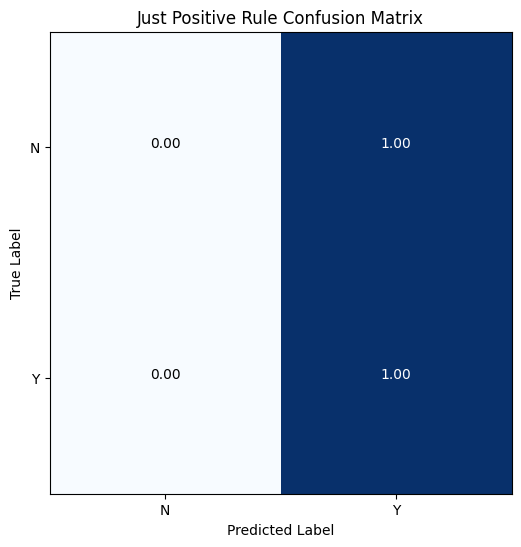

Classification Report:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00       363
           Y       0.94      1.00      0.97      5972

    accuracy                           0.94      6335
   macro avg       0.47      0.50      0.49      6335
weighted avg       0.89      0.94      0.91      6335

ALTHOUGH RULE PERFORMANCE


c:\Users\asge1\Downloads\nlp-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asge1\Downloads\nlp-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asge1\Downloads\nlp-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

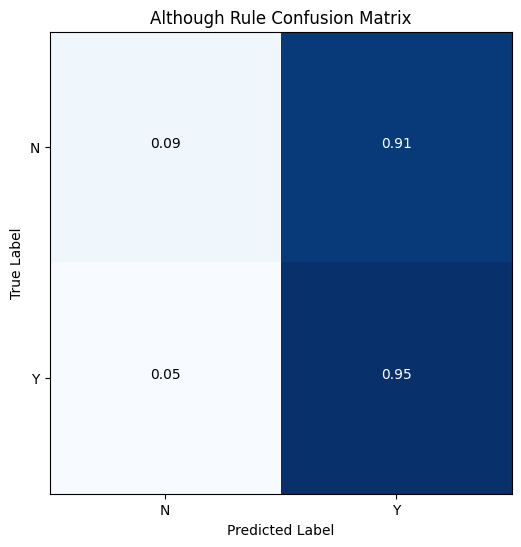

Classification Report:
              precision    recall  f1-score   support

           N       0.09      0.09      0.09       363
           Y       0.94      0.95      0.95      5972

    accuracy                           0.90      6335
   macro avg       0.52      0.52      0.52      6335
weighted avg       0.90      0.90      0.90      6335

DOES RULE PERFORMANCE


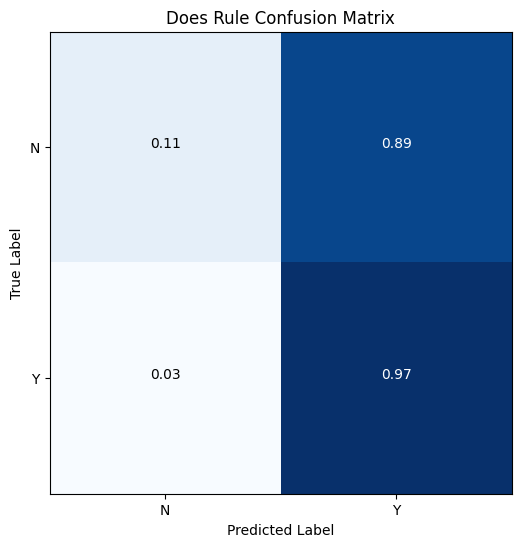

Classification Report:
              precision    recall  f1-score   support

           N       0.21      0.11      0.14       363
           Y       0.95      0.97      0.96      5972

    accuracy                           0.92      6335
   macro avg       0.58      0.54      0.55      6335
weighted avg       0.90      0.92      0.91      6335

FIRST LETTER RULE PERFORMANCE


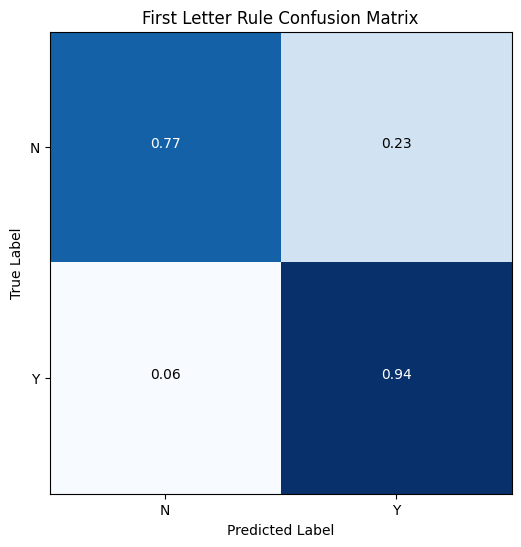

Classification Report:
              precision    recall  f1-score   support

           N       0.44      0.77      0.56       363
           Y       0.99      0.94      0.96      5972

    accuracy                           0.93      6335
   macro avg       0.71      0.86      0.76      6335
weighted avg       0.95      0.93      0.94      6335

WHEN RULE PERFORMANCE


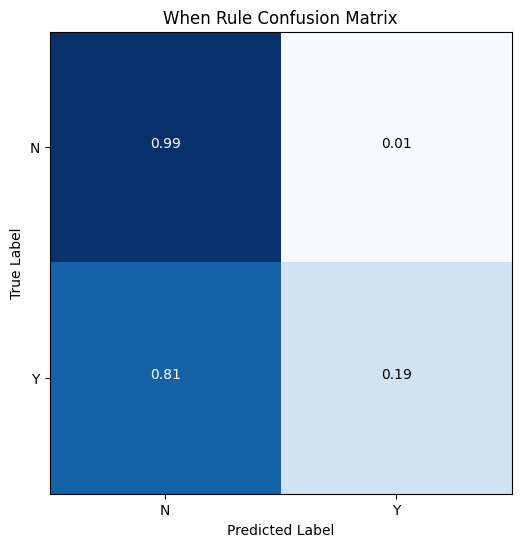

Classification Report:
              precision    recall  f1-score   support

           N       0.07      0.99      0.13       363
           Y       1.00      0.19      0.33      5972

    accuracy                           0.24      6335
   macro avg       0.53      0.59      0.23      6335
weighted avg       0.94      0.24      0.31      6335

COMBINED RULES PERFORMANCE


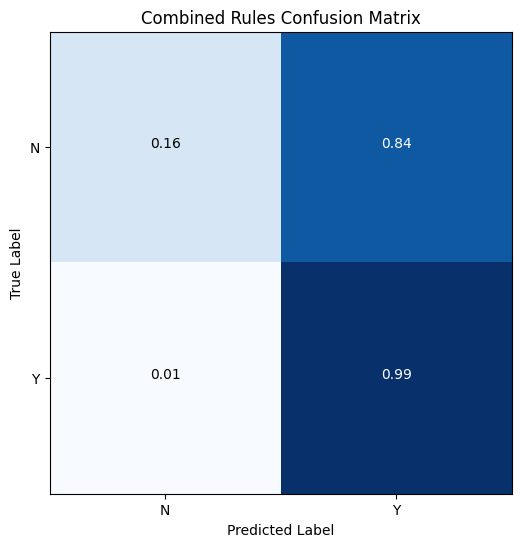

Classification Report:
              precision    recall  f1-score   support

           N       0.54      0.16      0.25       363
           Y       0.95      0.99      0.97      5972

    accuracy                           0.94      6335
   macro avg       0.74      0.58      0.61      6335
weighted avg       0.93      0.94      0.93      6335



In [4]:
# Performance of each individual rule
print("JUST POSITIVE RULE PERFORMANCE")
df_just_positive_rule = df_arkote.with_columns(just_positive_rule().alias("answerable_pred"))
display_results(df_just_positive_rule['answerable_pred'], df_just_positive_rule['answerable'], ["N", "Y"], "Just Positive Rule Confusion Matrix")

print("ALTHOUGH RULE PERFORMANCE")
df_although_rule = df_arkote.with_columns(although_rule().alias("answerable_pred"))
display_results(df_although_rule['answerable_pred'], df_although_rule['answerable'], ["N", "Y"], "Although Rule Confusion Matrix")

print("DOES RULE PERFORMANCE")
df_does_rule = df_arkote.with_columns(does_rule().alias("answerable_pred"))
display_results(df_does_rule['answerable_pred'], df_does_rule['answerable'], ["N", "Y"], "Does Rule Confusion Matrix")

print("FIRST LETTER RULE PERFORMANCE")
df_first_letter_rule = df_arkote.with_columns(first_letter_rule().alias("answerable_pred"))
display_results(df_first_letter_rule['answerable_pred'], df_first_letter_rule['answerable'], ["N", "Y"], "First Letter Rule Confusion Matrix")

print("WHEN RULE PERFORMANCE")
df_when_rule = df_arkote.with_columns(when_rule().alias("answerable_pred"))
display_results(df_when_rule['answerable_pred'], df_when_rule['answerable'], ["N", "Y"], "When Rule Confusion Matrix")

print("COMBINED RULES PERFORMANCE")
df_combined_rules = df_arkote.with_columns(rule_based_classification().alias("answerable_pred"))
display_results(df_combined_rules['answerable_pred'], df_combined_rules['answerable'], ["N", "Y"], "Combined Rules Confusion Matrix")



Combined dataset performance


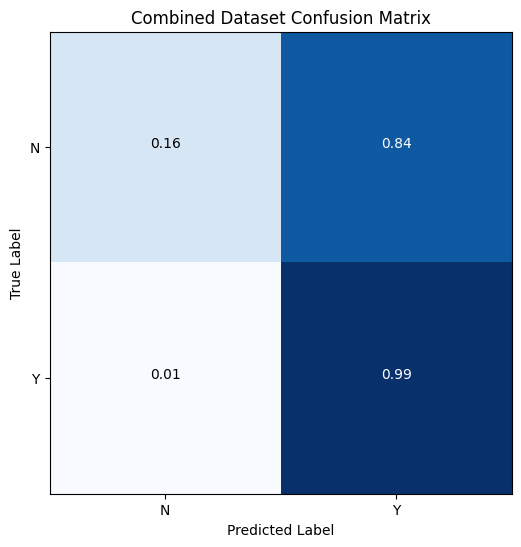

Classification Report:
              precision    recall  f1-score   support

           N       0.54      0.16      0.25       363
           Y       0.95      0.99      0.97      5972

    accuracy                           0.94      6335
   macro avg       0.74      0.58      0.61      6335
weighted avg       0.93      0.94      0.93      6335

Arabic dataset performance


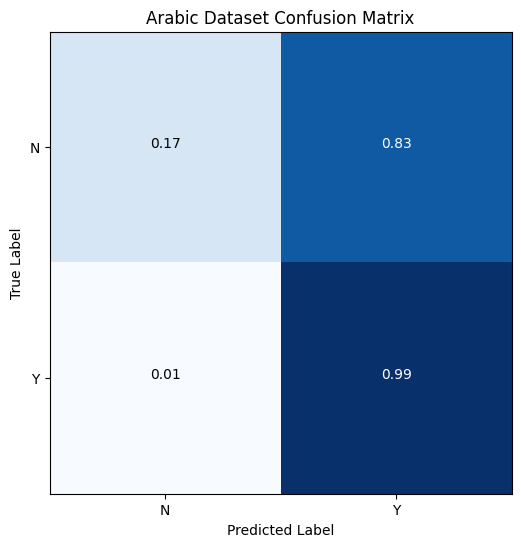

Classification Report:
              precision    recall  f1-score   support

           N       0.61      0.17      0.26       255
           Y       0.91      0.99      0.95      2303

    accuracy                           0.91      2558
   macro avg       0.76      0.58      0.61      2558
weighted avg       0.88      0.91      0.88      2558

Korean dataset performance


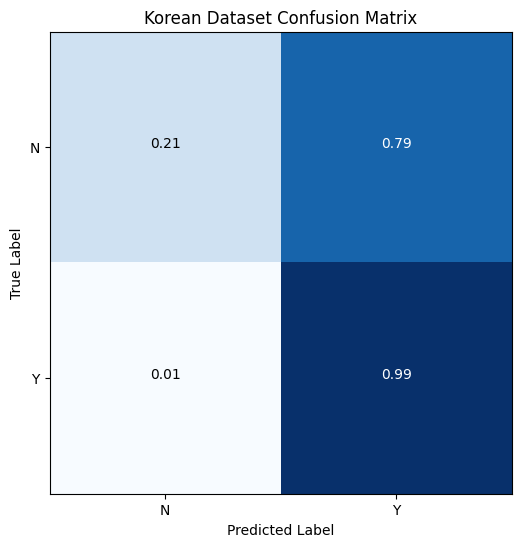

Classification Report:
              precision    recall  f1-score   support

           N       0.39      0.21      0.27        63
           Y       0.98      0.99      0.99      2359

    accuracy                           0.97      2422
   macro avg       0.69      0.60      0.63      2422
weighted avg       0.96      0.97      0.97      2422

Telugu dataset performance


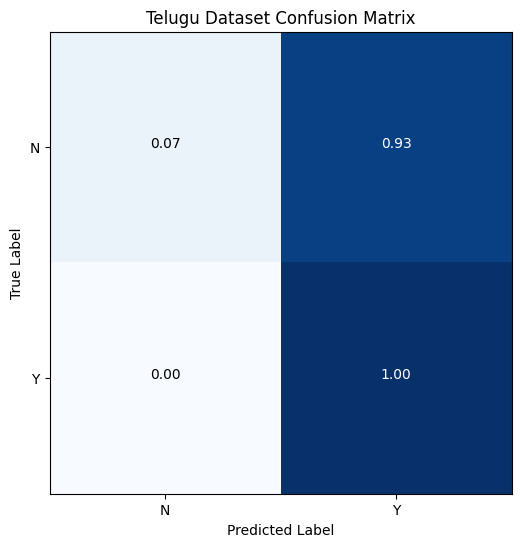

Classification Report:
              precision    recall  f1-score   support

           N       0.43      0.07      0.12        45
           Y       0.97      1.00      0.98      1310

    accuracy                           0.97      1355
   macro avg       0.70      0.53      0.55      1355
weighted avg       0.95      0.97      0.95      1355



In [5]:
print("Combined dataset performance")
df_combined_dataset = df_arkote.with_columns(rule_based_classification().alias("answerable_pred"))
display_results(df_combined_dataset['answerable_pred'], df_combined_dataset['answerable'], ["N", "Y"], "Combined Dataset Confusion Matrix")

print("Arabic dataset performance")
df_arabic = df_ar.with_columns(rule_based_classification().alias("answerable_pred"))
display_results(df_arabic['answerable_pred'], df_arabic['answerable'], ["N", "Y"], "Arabic Dataset Confusion Matrix")

print("Korean dataset performance")
df_korean = df_ko.with_columns(rule_based_classification().alias("answerable_pred"))
display_results(df_korean['answerable_pred'], df_korean['answerable'], ["N", "Y"], "Korean Dataset Confusion Matrix")

print("Telugu dataset performance")
df_telugu = df_te.with_columns(rule_based_classification().alias("answerable_pred"))
display_results(df_telugu['answerable_pred'], df_telugu['answerable'], ["N", "Y"], "Telugu Dataset Confusion Matrix")

# Load our own dataset

In [6]:
df_test_json = pl.read_json("test.json")
df_test_json.head()

question,context,lang,answerable,answer_start,answer,answer_inlang,translation
str,str,str,bool,i64,str,str,str
"""Which company published the vi…","""Hell's Kitchen: The Game is a …","""en""",true,164,"""Ubisoft""","""Ubisoft""","""Which company published the vi…"
"""八一大楼是什么时候完全建成的？""","""The first PLA main office in B…","""zh""",true,584,"""July 1999""","""1999年7月""","""When was the August 1st buildi…"
"""1650ల చివరలో 'Hareskoven'ను ఏ …","""Hareskov was severely damaged …","""te""",true,37,"""the Swedish""","""స్వీడిష్""","""Which country damaged 'Haresko…"
"""ఎముక పురుగులు దేని నుండి ఆహారం…","""Osedax is a genus of deep-sea …","""te""",true,208,"""whale carcasses""","""తిమింగల కళేబరాలు""","""What do boneworms feed on?"""
"""దోసకాయలు ఏ ఖండం నుండి ఉద్భవించ…","""Considered an annual plant, th…","""te""",true,180,"""Asia""","""ఆసియా""","""Which continent did cucumbers …"


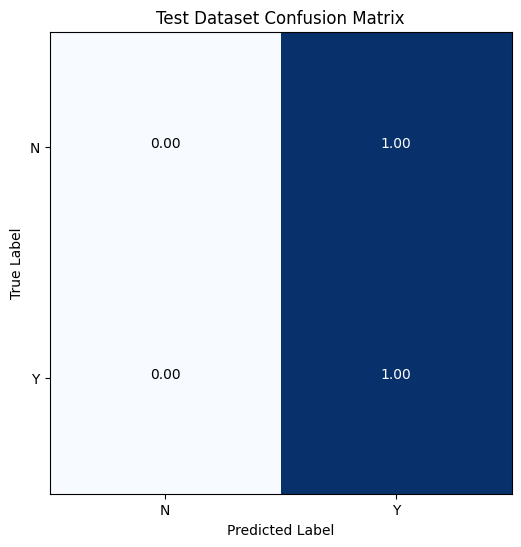

Classification Report:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00         4
           Y       0.80      1.00      0.89        16

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20



c:\Users\asge1\Downloads\nlp-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asge1\Downloads\nlp-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\asge1\Downloads\nlp-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [7]:

df_test_json_ = df_test_json.with_columns(rule_based_classification().alias("answerable_pred"))
display_results(df_test_json_['answerable_pred'], df_test_json_['answerable'], bio_labels=["N", "Y"], title="Test Dataset Confusion Matrix")